In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import *

In [ ]:
def ma(array: np.array, window: int, progress=trange) -> np.array:
    result = np.array([],dtype="float64")
    assert window > 1, "Window is too small!"
    assert len(array) > window, "Array passed to MA is too small!"
    s = sum(array[:window])
    for i in progress(window, len(array), 1):
            # NumPy? Nice.
            result=np.append(result, [float(s)/float(window)])
            s -= array[i-window]
            s += array[i]
    return result

In [ ]:
data = pd.read_csv("data/USDCHF.csv")

In [ ]:
plt.plot(data)
plt.grid()
plt.show()

In [ ]:
data.head()

In [ ]:
# Build candles
parse_date = lambda x: datetime.datetime.strptime(x.split(".")[0],"%Y-%m-%dT%H:%M:%S")
def build_candles(data,build_for="OPEN", frame=300):
    assert len(data) > 0
    d,o,h,l,c = [],[],[],[],[]
    current_time = parse_date(data["TIME"][0])
    o.append(data[build_for][0])
    h.append(data[build_for][0])
    l.append(data[build_for][0])
    c.append(data[build_for][0])
    d.append(data["TIME"][0])
    dates = []
    for i in trange(len(data)):
        tm = parse_date(data["TIME"][i])
        dt = tm - current_time
        if dt.seconds>=frame:
            # new candle
            current_time=tm
            d.append(data["TIME"][i])
            o.append(data[build_for][i])
            h.append(data[build_for][i])
            l.append(data[build_for][i])
            c.append(data[build_for][i])
        else:
            price = data[build_for][i]
            if price > h[-1]:
                h[-1] = price
            if price < l[-1]:
                l[-1] = price
            c[-1] = price
    return d,o,h,l,c
            

In [ ]:
d,o,h,l,c = build_candles(data)

In [ ]:
df = pd.DataFrame()
df.insert(0,"DATE", d[100:])
df.set_index("DATE")
df.insert(1,"OPEN", o[100:])
df.insert(2,"HIGH", h[100:])
df.insert(3,"LOW", l[100:])
df.insert(4,"CLOSE", c[100:])
for i in tnrange(5,100):
    df.insert(0, "OPEN_MA%d"%i, ma(o,i, progress=range)[100-i:])
    df.insert(0, "HIGH_MA%d"%i, ma(h,i, progress=range)[100-i:])
    df.insert(0, "LOW_MA%d"%i, ma(l,i, progress=range)[100-i:])
    df.insert(0, "CLOSE_MA%d"%i, ma(c,i, progress=range)[100-i:])

In [ ]:
df.to_csv(f"data/{data['SYM'][0]}_ma.csv")
# df = pd.read_csv("data/USDCHF_ma.csv")

In [ ]:
plt.plot(df["OPEN_MA99"][:200])
plt.plot(df["OPEN"][:200])
plt.grid()
plt.show()

In [ ]:
build_by = "CLOSE"
eps = 5*10**-5
Y = np.array([])
c_1 = 0
c_2 = 0
c_3 = 0
for i in tnrange(1,len(df),1):
    if df[build_by][i]-df[build_by][i-1] > eps:
        Y = np.append(Y, [1])
        c_1 += 1
    elif df[build_by][i-1]-df[build_by][i] > eps:
        Y = np.append(Y, [-1])
        c_2 += 1
    else:
        Y = np.append(Y, [0])
        c_3 += 1
print("Class 1: %.3f%%"%(100.0*c_1/len(df)))
print("Class 2: %.3f%%"%(100.0*c_2/len(df)))
print("Class 3: %.3f%%"%(100.0*c_3/len(df)))

In [ ]:
# Normalize df
df = (df-df.mean())/df.std()

In [ ]:
df2=df[:-1]
df2.insert(0,"CLASS",Y)
df2.to_csv(f"data/{data['SYM'][0]}_normalized.csv")

In [2]:
df = pd.read_csv("data/USD_CHF_normalized.csv")
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from sklearn.model_selection import train_test_split <-- do not work on aarch64

In [3]:
cuda=torch.cuda.is_available()
if cuda:
    print("Using CUDA")
    device = torch.device("cuda:0")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using CUDA


In [4]:
df = df.drop(columns=["Unnamed: 0"])
df = df.dropna(axis=1, how='all')

In [5]:
df.head()

,CLASS,CLOSE,CLOSE_MA10,CLOSE_MA11,CLOSE_MA12,CLOSE_MA13,CLOSE_MA14,CLOSE_MA15,CLOSE_MA16,CLOSE_MA17,...,OPEN_MA90,OPEN_MA91,OPEN_MA92,OPEN_MA93,OPEN_MA94,OPEN_MA95,OPEN_MA96,OPEN_MA97,OPEN_MA98,OPEN_MA99
0,-1.0,0.268902,0.298462,0.298857,0.299669,0.300866,0.301595,0.301284,0.301635,0.301553,...,0.309046,0.308151,0.307385,0.307011,0.306521,0.306225,0.305926,0.305797,0.305593,0.305360
1,-1.0,0.262262,0.295058,0.295762,0.296347,0.297288,0.298569,0.299402,0.299247,0.299696,...,0.309185,0.308435,0.307557,0.306805,0.306441,0.305962,0.305674,0.305384,0.305262,0.305065
2,-1.0,0.248982,0.290740,0.292063,0.292956,0.293711,0.294773,0.296135,0.297067,0.297058,...,0.309388,0.308756,0.308019,0.307154,0.306414,0.306058,0.305588,0.305307,0.305024,0.304905
3,-1.0,0.232381,0.284762,0.286929,0.288458,0.289559,0.290502,0.291706,0.293174,0.294224,...,0.309490,0.308820,0.308200,0.307477,0.306627,0.305900,0.305553,0.305092,0.304819,0.304544
4,1.0,0.212461,0.275462,0.279985,0.282369,0.284129,0.285460,0.286612,0.287983,0.289583,...,0.309416,0.308810,0.308155,0.307548,0.306840,0.306005,0.305293,0.304955,0.304505,0.304241


In [6]:
X = np.array(df)
X = np.delete(X, len(X[0])-1, 1)
Y = np.array(df["CLASS"])

In [7]:
X.shape

(50159, 384)

In [8]:
Y.shape

(50159,)

In [9]:
# We should NOT shuffle train/test data, since it may bias backtesting result
X_train, X_test, Y_train, Y_test = [],[],[],[]
TRAIN_FACTOR = 0.7
for i in tnrange(len(df)):
    if i < TRAIN_FACTOR*len(df):
        X_train.append(X[i])
        Y_train.append(Y[i])
    else:
        X_test.append(X[i])
        Y_test.append(Y[i]) 
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

  0%|          | 0/50159 [00:00<?, ?it/s]

In [10]:
model = nn.Sequential(
    nn.Linear(384,384),
    nn.Tanh(),
    nn.Linear(384,285),
    nn.LeakyReLU(),
    nn.Linear(285,185),
    nn.Tanh(),
    nn.Linear(185,85),
    nn.ELU(),
    nn.Linear(85,3),
    nn.Softmax()
)
criterion = nn.CrossEntropyLoss().to(device) # <--- WORST LOSS IMPLEMENTATION EVER!!1
optimizer = optim.SGD(model.parameters(), lr = 0.01)
model = model.to(device)

In [11]:
BATCH_SIZE = 128
N_EPOCHS = 100
def get_targets(Y):
    Y_targets = []
    for x in Y:
        assert x in [-1,0,1]
        if x==-1:
            Y_targets.append([1,0,0])
        if x==0:
            Y_targets.append([0,1,0])
        if x==1:
            Y_targets.append([0,0,1])
    return Y_targets

In [12]:
losses = []
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], BATCH_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(BATCH_SIZE):
        x = torch.Tensor(sample_x[j]).to(device)
        target = torch.Tensor([sample_y[j]+1]).type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        output = model(x)
        #print(output)
        output = output.reshape((1,3)).float()
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= BATCH_SIZE
    losses.append(avg_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/p01ar/.local/lib/python3.6/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [13]:
losses[:5]

[1.0970416059717536,
 1.0929093966260552,
 1.098976280540228,
 1.087204116396606,
 1.0902032158337533]

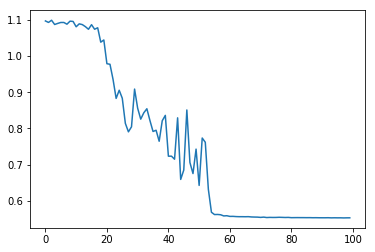

In [14]:
plt.plot(losses)
plt.show()

In [15]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in tnrange(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float().to(device)
        y = Y[i]
        _y = model(x)
        if _y[0] > _y[1] and _y[0] > _[2]:
            cls = -1
        elif _y[1] > _y[2] and _y[1]>_y[0]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [16]:
acc(X_test, Y_test)

  0%|          | 0/15047 [00:00<?, ?it/s]

0.6569415830398087

In [48]:
# TODO: Deeper anlysis of misclassification, dataset improvements(corelation, lags, etc.), backtesting

In [23]:
df = pd.read_csv("data/dataset.csv")
df.head()

,Date,Open_F_x,Open_AAPL_x,Open_AAL_x,Open_BAC_x,Open_VALE_x,Open_CCL_x,Open_ABEV_x,Open_BB_x,Open_FCEL_x,...,Open_AMD_avg_100,Open_BBD_avg_100,Open_ITUB_avg_100,Open_CLF_avg_100,Open_NVDA_avg_100,Open_RIG_avg_100,Open_XOM_avg_100,Open_X_avg_100,Open_WFC_avg_100,Label
0,2007-02-09,-0.602092,-0.876091,2.070348,2.485201,-0.029368,0.655116,-1.502131,0.539258,2.007668,...,0.191135,-0.314110,-0.588491,-0.215817,-0.512883,1.410122,-0.397819,0.989069,-0.344069,"[1, 0, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1,..."
1,2007-02-12,-0.629721,-0.877661,2.014846,2.475456,-0.039635,0.607422,-1.496585,0.511186,1.999984,...,0.186069,-0.309057,-0.582948,-0.212909,-0.512753,1.412389,-0.390529,0.997046,-0.344319,"[-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1..."
2,2007-02-13,-0.690506,-0.876871,2.042292,2.466522,-0.032220,0.590221,-1.497225,0.496472,1.965404,...,0.180621,-0.304900,-0.577825,-0.210158,-0.512615,1.413621,-0.384490,1.005633,-0.344535,"[-1, 0, 1, -1, 1, -1, 0, -1, -1, 1, 1, -1, -1,..."
3,2007-02-14,-0.704320,-0.877444,1.963003,2.520936,0.061895,0.590221,-1.486772,0.498768,1.969246,...,0.175141,-0.300211,-0.572497,-0.206988,-0.512454,1.416018,-0.376938,1.014660,-0.344638,"[-1, 0, -1, 1, 1, 0, 1, 1, 1, 1, -1, -1, 1, -1..."
4,2007-02-15,-0.676691,-0.876568,1.963613,2.546925,0.130341,0.598821,-1.455200,0.530179,1.957719,...,0.169662,-0.293980,-0.565702,-0.203855,-0.512350,1.418275,-0.369023,1.023687,-0.344802,"[1, 0, 0, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1..."


In [50]:
X_train, X_test, Y_train, Y_test = [],[],[],[]
X = np.array(df.drop(["Label","Date"], axis=1))
Y = df["Label"]
TRAIN_FACTOR = 0.7
for i in tnrange(len(df)):
    if i < TRAIN_FACTOR*len(df):
        X_train.append(X[i])
        Y_train.append(eval(Y[i])[5])
    else:
        X_test.append(X[i])
        Y_test.append(eval(Y[i])[5]) 
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

  0%|          | 0/3670 [00:00<?, ?it/s]

In [51]:
X.shape

(3670, 3960)

In [52]:
Y.shape

(3670,)

In [53]:
model = nn.Sequential(
    nn.Linear(3960,3960),
    nn.Tanh(),
    nn.Linear(3960,2000),
    nn.LeakyReLU(),
    nn.Linear(2000,1000),
    nn.Tanh(),
    nn.Linear(1000,100),
    nn.ELU(),
    nn.Linear(100,3),
    nn.Softmax()
)
criterion = nn.CrossEntropyLoss().to(device) # <--- WORST LOSS IMPLEMENTATION EVER!!1
optimizer = optim.SGD(model.parameters(), lr = 0.01)
model = model.to(device)

In [54]:
losses = []
BATCH_SIZE = 32
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], BATCH_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(BATCH_SIZE):
        x = torch.Tensor(sample_x[j]).to(device)
        target = torch.Tensor([sample_y[j]+1]).type(torch.LongTensor).to(device)
        optimizer.zero_grad()
        output = model(x)
        #print(output)
        output = output.reshape((1,3)).float()
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= BATCH_SIZE
    losses.append(avg_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

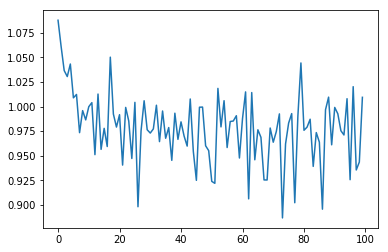

In [55]:
plt.plot(losses)
plt.show()

In [17]:
prices = pd.read_csv("data/USD_CHF.csv")

50159

In [18]:
len(df)

50159

In [19]:
prices = prices[1:]

50160

In [57]:
test_prices = []
for i in tnrange(len(df)):
    if i >= TRAIN_FACTOR*len(df):
        test_prices.append((prices["OPEN"][i], prices["HIGH"][i],prices["LOW"][i],))
len(test_prices)

  0%|          | 0/50159 [00:00<?, ?it/s]

15047

In [58]:
len(X_test)

15047

In [63]:
def get_cls(out):
    if out[0] > out[1] and out[0] > out[2]:
            cls = -1
    elif out[1] > out[2] and out[1] > out[0]:
            cls = 0
    else:
            cls = 1
    return cls

In [74]:
balance = 100000.0
pl = 0.0
pl_dynamics = []
entry_price = None
is_buy = None
for i in tnrange(len(test_prices)):
    if entry_price is not None:
        if is_buy:
            pl += prices["CLOSE"][i]*100.0-entry_price*100.0
            entry_price = None
            is_buy = None
        else:
            pl += entry_price*100.0 - prices["CLOSE"][i]*100.0
            is_buy = None
            entry_price = None
    pl_dynamics.append(pl)
    out = model(torch.Tensor(X_test[i]).to(device))
    prediction = get_cls(out)
    if prediction == 1:
        entry_price = test_prices[i][0]
        is_buy = True
    if prediction == -1:
        entry_price = test_prices[i][0]
        is_buy = False
    

  0%|          | 0/15047 [00:00<?, ?it/s]

In [75]:
pl

119.32499999999844

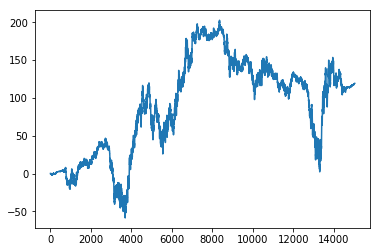

In [76]:
plt.plot(pl_dynamics)
plt.show()